In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

# Image processing
import cv2
from PIL import Image

# Utility imports
import os
import random
from glob import glob
from datetime import datetime
from typing import Tuple, List, Dict
import gc

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Check GPU availability
print("🖥️ Hardware Configuration:")
print(f"TensorFlow Version: {tf.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"GPU Available (TF): {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"GPU Available (PyTorch): {torch.cuda.is_available()}")

if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

🖥️ Hardware Configuration:
TensorFlow Version: 2.18.0
PyTorch Version: 2.6.0+cu124
GPU Available (TF): False
GPU Available (PyTorch): False


#Mengambil Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define dataset path - Update this with your actual path
DATASET_PATH = '/content/drive/MyDrive/dataset_ikan/FishImgDataset'
print(f"📂 Dataset Path: {DATASET_PATH}")

# Define paths for train, validation, and test
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')
TEST_PATH = os.path.join(DATASET_PATH, 'test')

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 64
NUM_CLASSES = 31
MAX_EPOCHS = 50
SAMPLE_SIZE = 1.0

# 1) Print out the root folder contents
print("Root folder contents:", os.listdir(DATASET_PATH))

# 2) Verify the three key subfolders exist
for split in ("train", "val", "test"):
    path = os.path.join(DATASET_PATH, split)
    print(f"{split:5s} exists:", os.path.isdir(path))
    # show first few filenames if it exists
    if os.path.isdir(path):
        print(f"  → {split} sample files:", os.listdir(path)[:5])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Dataset Path: /content/drive/MyDrive/fish-dataset/FishImgDataset
Root folder contents: ['train', 'val', 'test']
train exists: True
  → train sample files: ['Silver Perch', 'Scat Fish', 'Tenpounder', 'Pangasius', 'Snakehead']
val   exists: True
  → val sample files: ['Tilapia', 'Snakehead', 'Tenpounder', 'Silver Carp', 'Pangasius']
test  exists: True
  → test sample files: ['Silver Perch', 'Scat Fish', 'Perch', 'Silver Carp', 'Tilapia']


#Eksplorasi Data


📁 TRAIN set:
Number of species: 31
Total images: 8535
Sample species: ['Silver Perch', 'Scat Fish', 'Tenpounder', 'Pangasius', 'Snakehead', 'Silver Carp', 'Tilapia', 'Silver Barb', 'Perch', 'Indo-Pacific Tarpon', 'Knifefish', 'Mosquito Fish', 'Jaguar Gapote', 'Indian Carp', 'Green Spotted Puffer', 'Long-Snouted Pipefish', 'Mudfish', 'Mullet', 'Janitor Fish', 'Black Spotted Barb', 'Gold Fish', 'Glass Perchlet', 'Freshwater Eel', 'Catfish', 'Grass Carp', 'Goby', 'Fourfinger Threadfin', 'Gourami', 'Climbing Perch', 'Bangus', 'Big Head Carp']

📁 VAL set:
Number of species: 31
Total images: 2675
Sample species: ['Tilapia', 'Snakehead', 'Tenpounder', 'Silver Carp', 'Pangasius', 'Silver Barb', 'Perch', 'Mullet', 'Silver Perch', 'Scat Fish', 'Long-Snouted Pipefish', 'Indo-Pacific Tarpon', 'Mudfish', 'Knifefish', 'Grass Carp', 'Janitor Fish', 'Indian Carp', 'Jaguar Gapote', 'Green Spotted Puffer', 'Mosquito Fish', 'Gold Fish', 'Black Spotted Barb', 'Gourami', 'Freshwater Eel', 'Fourfinger Thre

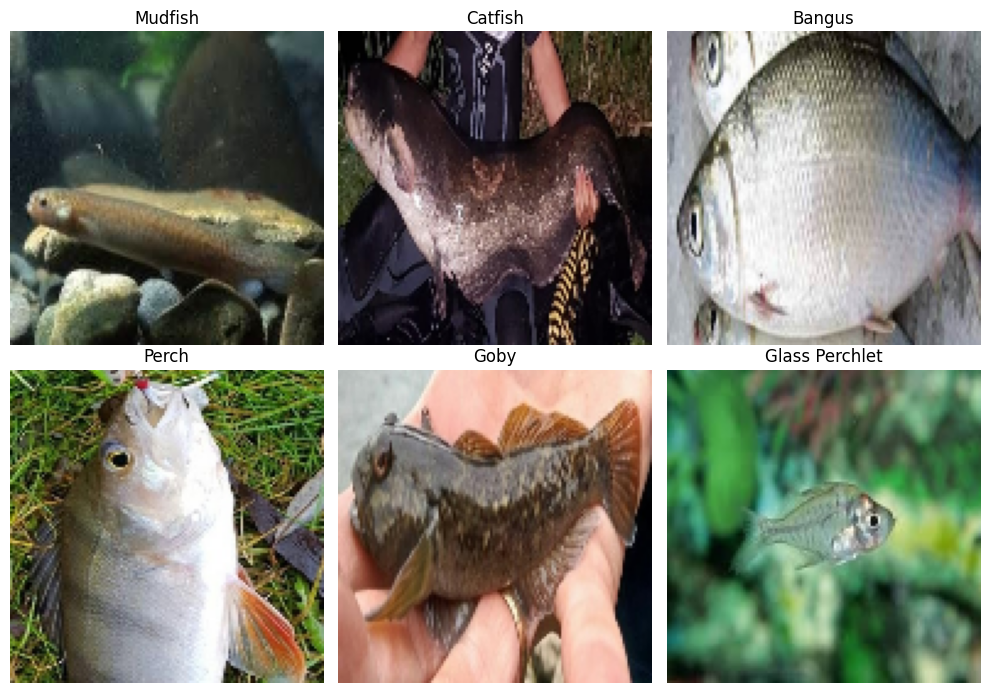

In [ ]:
def explore_dataset(base_path: str) -> Dict:
    """
    Explore the fish image dataset structure.
    """
    dataset_info = {
        'train': {},
        'val': {},
        'test': {}
    }

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(base_path, split)
        if os.path.exists(split_path):
            species_folders = [f for f in os.listdir(split_path)
                             if os.path.isdir(os.path.join(split_path, f))]

            print(f"\n📁 {split.upper()} set:")
            print(f"Number of species: {len(species_folders)}")

            total_images = 0
            species_counts = {}

            for species in species_folders:
                species_path = os.path.join(split_path, species)
                images = glob(os.path.join(species_path, '*.[jp][pn][g]'))
                species_counts[species] = len(images)
                total_images += len(images)

            dataset_info[split] = {
                'species': species_folders,
                'species_counts': species_counts,
                'total_images': total_images
            }

            print(f"Total images: {total_images}")
            print(f"Sample species: {list(species_counts.keys())}")

    return dataset_info

# Explore the dataset
dataset_info = explore_dataset(DATASET_PATH)

# Create species to index mapping
all_species = sorted(dataset_info['train']['species'])
species_to_idx = {species: idx for idx, species in enumerate(all_species)}
idx_to_species = {idx: species for species, idx in species_to_idx.items()}

print(f"\n🐟 Total fish species: {len(species_to_idx)}")


#Visualize Sample Images (Quick)
def visualize_samples(base_path: str, species_to_idx: Dict, n_samples: int = 6):
    """
    Quickly visualize sample images.
    """
    train_path = os.path.join(base_path, 'train')
    selected_species = random.sample(list(species_to_idx.keys()), min(n_samples, len(species_to_idx)))

    fig, axes = plt.subplots(2, 3, figsize=(10, 7))
    axes = axes.flatten()

    for idx, species in enumerate(selected_species[:n_samples]):
        species_path = os.path.join(train_path, species)
        images = glob(os.path.join(species_path, '*.[jp][pn][g]'))

        if images:
            img_path = random.choice(images)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))

            axes[idx].imshow(img)
            axes[idx].set_title(f'{species}')
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(DATASET_PATH, species_to_idx)

#Data Preprocessing

#Feature Engineering

In [ ]:
def create_size_bins(sizes: np.ndarray, n_bins: int = 5) -> Tuple[np.ndarray, List[str]]:
    """
    Convert continuous sizes to categorical bins.
    """
    # Create equal-width bins
    bins = np.linspace(0, 100, n_bins + 1)
    bin_labels = []

    for i in range(n_bins):
        bin_labels.append(f"Size {int(bins[i])}-{int(bins[i+1])}")

    # Digitize sizes into bins
    size_categories = np.digitize(sizes, bins) - 1
    size_categories = np.clip(size_categories, 0, n_bins - 1)

    return size_categories, bin_labels

# Example of binning
sample_sizes = np.array([s for _, s, _ in train_dataset][:100])
size_categories, bin_labels = create_size_bins(sample_sizes)
print(f"Size bins created: {bin_labels}")


Size bins created: ['Size 0-20', 'Size 20-40', 'Size 40-60', 'Size 60-80', 'Size 80-100']


#Implementasi Model

## TensorFlow/Keras

In [ ]:
class SimpleTensorFlowCNN:
    """
    Optimized CNN for faster training - Regression task.
    """

    def __init__(self, learning_rate: float = 0.001):
        self.learning_rate = learning_rate
        self.model = None
        self.history = None

    def build_model(self) -> keras.Model:
        """
        Build simplified CNN for regression.
        """
        model = keras.Sequential([
            # Input layer
            layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

            # Conv Block 1
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Conv Block 2
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Conv Block 3
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),

            # Dense layers
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='linear')  # Regression output
        ])

        # Compile
        model.compile(
            optimizer=keras.optimizers.Adam(self.learning_rate),
            loss='mse',
            metrics=['mae']
        )

        self.model = model
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs: int = 10):
        """
        Fast training with early stopping.
        """
        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-6
        )

        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=BATCH_SIZE,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )

        return self.history

    def predict(self, X):
        """Make predictions."""
        return self.model.predict(X, verbose=0).ravel()

# Prepare data for TensorFlow
def prepare_tf_data(data_loader):
    """Convert PyTorch data loader to numpy arrays."""
    X_list = []
    y_list = []

    for images, targets, _ in data_loader:
        # Denormalize and convert to numpy
        images_np = images.numpy().transpose(0, 2, 3, 1)
        # Denormalize
        images_np = images_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        images_np = np.clip(images_np, 0, 1)

        X_list.append(images_np)
        y_list.append(targets.numpy())

    return np.vstack(X_list), np.hstack(y_list)

print("🔨 Preparing TensorFlow data...")
X_train_tf, y_train_tf = prepare_tf_data(train_loader)
X_val_tf, y_val_tf = prepare_tf_data(val_loader)
X_test_tf, y_test_tf = prepare_tf_data(test_loader)

print("🔨 Building TensorFlow CNN...")
tf_cnn = SimpleTensorFlowCNN()
tf_model = tf_cnn.build_model()
print(tf_model.summary())

print("\n🏋️ Training TensorFlow CNN...")
tf_history = tf_cnn.train(X_train_tf, y_train_tf, X_val_tf, y_val_tf, epochs=MAX_EPOCHS)

🔨 Preparing TensorFlow data...
🔨 Building TensorFlow CNN...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

None

🏋️ Training TensorFlow CNN...
Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 558s 4s/step - loss: 2625.4502 - mae: 45.8688 - val_loss: 741.8689 - val_mae: 22.5805 - learning_rate: 0.0010
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 550s 4s/step - loss: 794.1724 - mae: 22.4876 - val_loss: 1163.5728 - val_mae: 28.9273 - learning_rate: 0.0010
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 547s 4s/step - loss: 520.9406 - mae: 18.3233 - val_loss: 416.0287 - val_mae: 16.6505 - learning_rate: 0.0010
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 544s 4s/step - loss: 454.4230 - mae: 17.1511 - val_loss: 376.5848 - val_mae: 15.7601 - learning_rate: 0.0010
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 563s 4s/step - loss: 431.9021 - mae: 16.8657 - val_loss: 355.9734 - val_mae: 15.4131 - learning_rate: 0.0010
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 544s 4s/step - loss: 425.5336 - mae: 16.7687 - val_loss: 364.4457 - val_mae: 15.5636 - learning_rate: 0.0010
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 556s 4s/step - loss: 419.771

##PyTorch

In [ ]:
class SimplePyTorchCNN(nn.Module):
    """
    Optimized CNN for faster training - Regression task.
    """

    def __init__(self):
        super(SimplePyTorchCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(128, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)  # Regression output

    def forward(self, x):
        # Conv blocks
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        x = self.global_pool(torch.relu(self.bn3(self.conv3(x))))

        # Flatten
        x = x.view(x.size(0), -1)

        # Dense layers
        x = torch.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)

        return x.squeeze()

class FastPyTorchTrainer:
    """
    Optimized trainer for faster execution.
    """

    def __init__(self, model, learning_rate=0.001):
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.train_losses = []
        self.val_losses = []

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0.0

        for images, targets, _ in train_loader:
            images = images.to(self.device)
            targets = targets.float().to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        return total_loss / len(train_loader)

    def validate(self, val_loader):
        self.model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for images, targets, _ in val_loader:
                images = images.to(self.device)
                targets = targets.float().to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()

        return total_loss / len(val_loader)

    def train(self, train_loader, val_loader, epochs=10):
        best_val_loss = float('inf')
        patience = 0

        for epoch in range(epochs):
            train_loss = self.train_epoch(train_loader)
            val_loss = self.validate(val_loader)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience = 0
                torch.save(self.model.state_dict(), 'best_pytorch_model.pth')
            else:
                patience += 1

            if patience >= 3:
                print(f"Early stopping at epoch {epoch+1}")
                break

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Load best model
        self.model.load_state_dict(torch.load('best_pytorch_model.pth'))

    def predict(self, test_loader):
        self.model.eval()
        predictions = []

        with torch.no_grad():
            for images, _, _ in test_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                predictions.extend(outputs.cpu().numpy())

        return np.array(predictions)

# Build and train PyTorch model
print("\n🔨 Building PyTorch CNN...")
pytorch_cnn = SimplePyTorchCNN()
print(pytorch_cnn)

print("\n🏋️ Training PyTorch CNN...")
pytorch_trainer = FastPyTorchTrainer(pytorch_cnn)
pytorch_trainer.train(train_loader, val_loader, epochs=MAX_EPOCHS)


🔨 Building PyTorch CNN...
SimplePyTorchCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, o

#Evaluasi Model

🔮 Making predictions...

📊 TensorFlow CNN - Classification Metrics (from Regression):
Accuracy:    0.3507
Precision:   0.2253
Recall:      0.3507
F1-Score:    0.2665
AUC-ROC:     0.5383

📊 PyTorch CNN - Classification Metrics (from Regression):
Accuracy:    0.3877
Precision:   0.2540
Recall:      0.3877
F1-Score:    0.3001
AUC-ROC:     0.5722


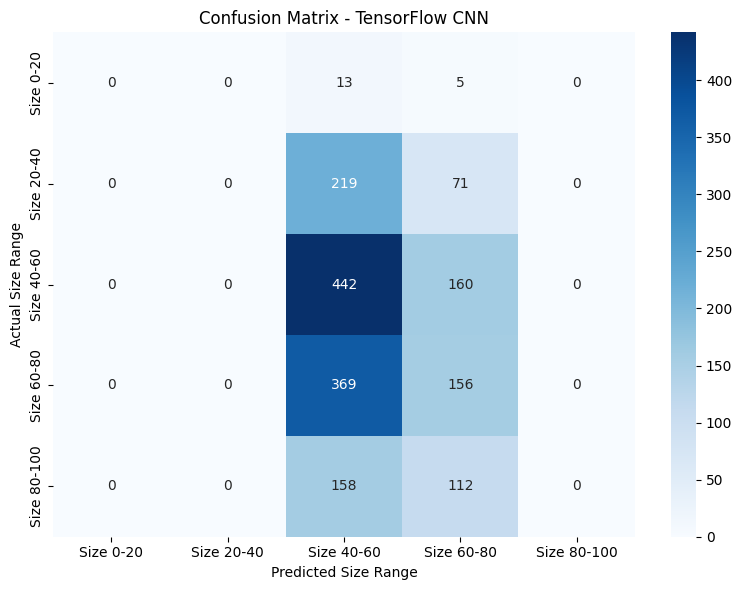

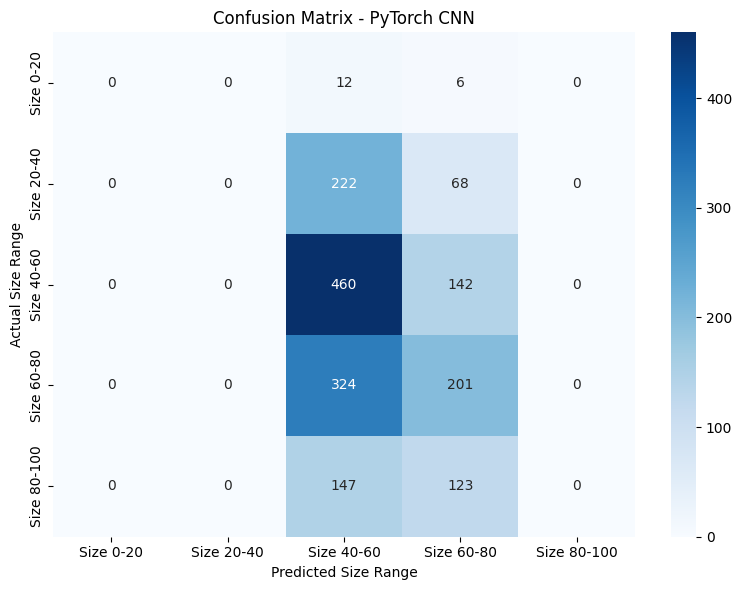

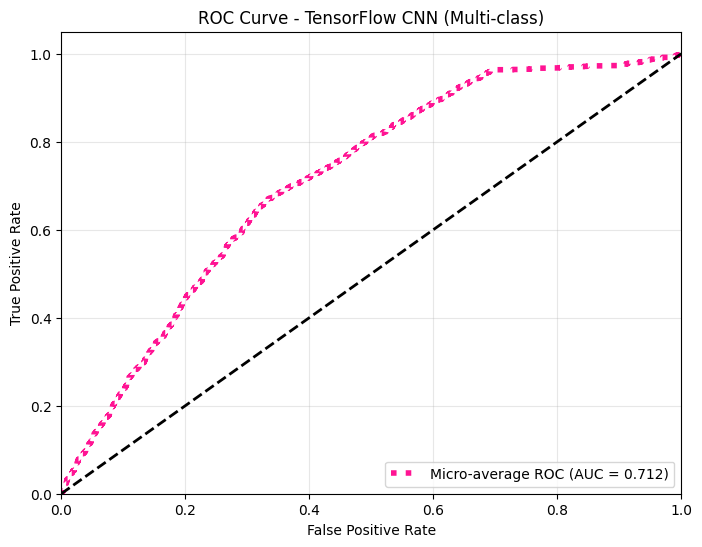

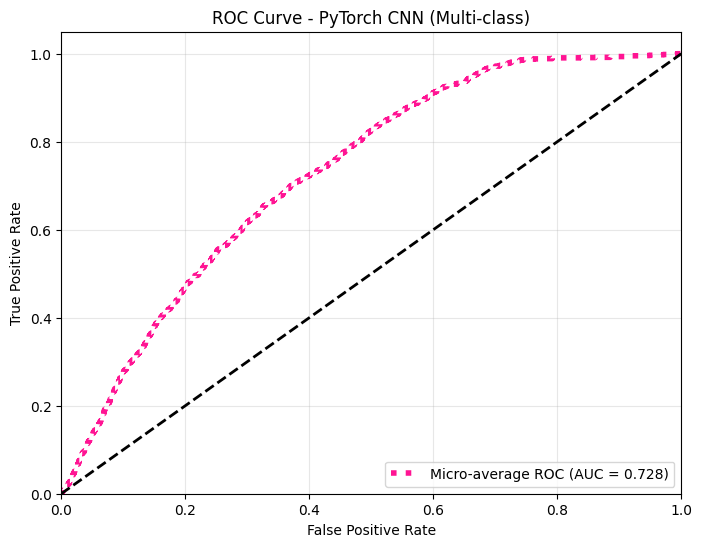

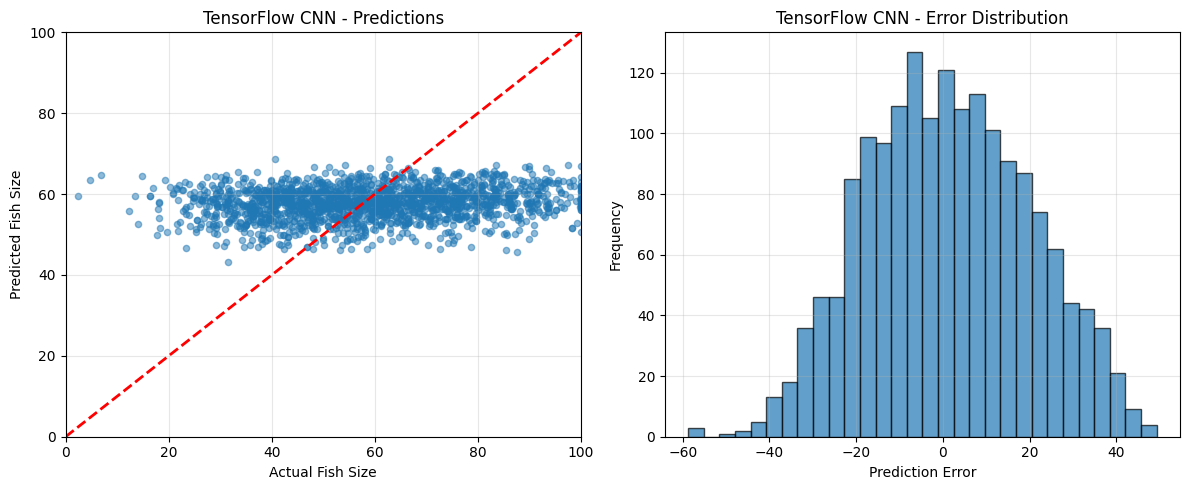

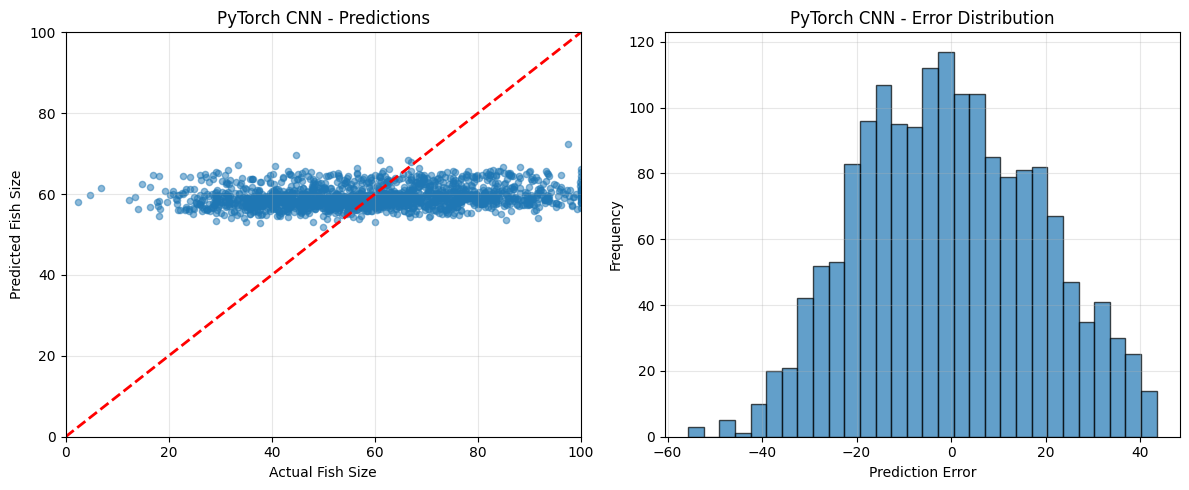

In [ ]:
class RegressionToClassificationEvaluator:
    """
    Evaluates regression models using classification metrics.
    """

    def __init__(self, n_bins=5):
        self.n_bins = n_bins
        self.bin_edges = np.linspace(0, 100, n_bins + 1)
        self.bin_labels = [f"Size {int(self.bin_edges[i])}-{int(self.bin_edges[i+1])}"
                          for i in range(n_bins)]

    def regression_to_classification(self, y_true, y_pred):
        """
        Convert regression predictions to classification bins.
        """
        # Clip predictions to valid range
        y_pred = np.clip(y_pred, 0, 100)

        # Convert to bins
        y_true_bins = np.digitize(y_true, self.bin_edges) - 1
        y_pred_bins = np.digitize(y_pred, self.bin_edges) - 1

        # Clip to valid bin range
        y_true_bins = np.clip(y_true_bins, 0, self.n_bins - 1)
        y_pred_bins = np.clip(y_pred_bins, 0, self.n_bins - 1)

        return y_true_bins, y_pred_bins

    def evaluate(self, y_true, y_pred, model_name):
        """
        Calculate all required metrics: Accuracy, Precision, Recall, F1-Score, AUC-ROC.
        """
        # Convert to classification
        y_true_bins, y_pred_bins = self.regression_to_classification(y_true, y_pred)

        # Calculate metrics
        accuracy = accuracy_score(y_true_bins, y_pred_bins)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true_bins, y_pred_bins, average='weighted', zero_division=0
        )

        # For AUC-ROC, we need probability scores
        # We'll use the distance from bin centers as confidence scores
        n_samples = len(y_true)
        y_scores = np.zeros((n_samples, self.n_bins))

        for i in range(n_samples):
            # Calculate distance from each bin center
            for j in range(self.n_bins):
                bin_center = (self.bin_edges[j] + self.bin_edges[j+1]) / 2
                distance = abs(y_pred[i] - bin_center)
                y_scores[i, j] = 1 / (1 + distance)  # Convert distance to similarity score

        # Normalize scores
        y_scores = y_scores / y_scores.sum(axis=1, keepdims=True)

        # Calculate AUC-ROC
        try:
            if self.n_bins == 2:
                # Binary classification
                auc_score = roc_auc_score(y_true_bins, y_scores[:, 1])
            else:
                # Multi-class
                y_true_binarized = label_binarize(y_true_bins, classes=list(range(self.n_bins)))
                auc_score = roc_auc_score(y_true_binarized, y_scores, multi_class='ovr', average='weighted')
        except:
            auc_score = 0.5  # Default if calculation fails

        # Print results
        print(f"\n📊 {model_name} - Classification Metrics (from Regression):")
        print("=" * 60)
        print(f"Accuracy:    {accuracy:.4f}")
        print(f"Precision:   {precision:.4f}")
        print(f"Recall:      {recall:.4f}")
        print(f"F1-Score:    {f1:.4f}")
        print(f"AUC-ROC:     {auc_score:.4f}")

        return {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC-ROC': auc_score
        }, y_true_bins, y_pred_bins, y_scores

    def plot_confusion_matrix(self, y_true_bins, y_pred_bins, model_name):
        """
        Plot confusion matrix.
        """
        cm = confusion_matrix(y_true_bins, y_pred_bins)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.bin_labels,
                   yticklabels=self.bin_labels)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted Size Range')
        plt.ylabel('Actual Size Range')
        plt.tight_layout()
        plt.show()

    def plot_roc_curve(self, y_true_bins, y_scores, model_name):
        """
        Plot ROC curve.
        """
        if self.n_bins == 2:
            # Binary classification
            fpr, tpr, _ = roc_curve(y_true_bins, y_scores[:, 1])
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2,
                    label=f'ROC curve (AUC = {roc_auc:.3f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {model_name}')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)
            plt.show()
        else:
            # Multi-class - show micro-average ROC
            y_true_binarized = label_binarize(y_true_bins, classes=list(range(self.n_bins)))

            fpr = dict()
            tpr = dict()
            roc_auc = dict()

            # Compute micro-average ROC curve
            fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_scores.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

            plt.figure(figsize=(8, 6))
            plt.plot(fpr["micro"], tpr["micro"],
                    label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.3f})',
                    color='deeppink', linestyle=':', linewidth=4)

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {model_name} (Multi-class)')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)
            plt.show()

#Evaluate Both Models
# Initialize evaluator
evaluator = RegressionToClassificationEvaluator(n_bins=5)

# Get predictions
print("🔮 Making predictions...")

# TensorFlow predictions
tf_predictions = tf_cnn.predict(X_test_tf)

# PyTorch predictions
pytorch_predictions = pytorch_trainer.predict(test_loader)

# Get true values
y_true = y_test_tf  # Same for both models

# Evaluate TensorFlow model
tf_metrics, tf_true_bins, tf_pred_bins, tf_scores = evaluator.evaluate(
    y_true, tf_predictions, "TensorFlow CNN"
)

# Evaluate PyTorch model
pytorch_metrics, pt_true_bins, pt_pred_bins, pt_scores = evaluator.evaluate(
    y_true, pytorch_predictions, "PyTorch CNN"
)

#Visualize Results
# Plot confusion matrices
evaluator.plot_confusion_matrix(tf_true_bins, tf_pred_bins, "TensorFlow CNN")
evaluator.plot_confusion_matrix(pt_true_bins, pt_pred_bins, "PyTorch CNN")

# Plot ROC curves
evaluator.plot_roc_curve(tf_true_bins, tf_scores, "TensorFlow CNN")
evaluator.plot_roc_curve(pt_true_bins, pt_scores, "PyTorch CNN")

#Prediction vs Actual Visualization
def plot_regression_predictions(y_true, y_pred, model_name):
    """
    Visualize regression predictions.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Scatter plot
    axes[0].scatter(y_true, y_pred, alpha=0.5, s=20)
    axes[0].plot([0, 100], [0, 100], 'r--', lw=2)
    axes[0].set_xlabel('Actual Fish Size')
    axes[0].set_ylabel('Predicted Fish Size')
    axes[0].set_title(f'{model_name} - Predictions')
    axes[0].set_xlim([0, 100])
    axes[0].set_ylim([0, 100])
    axes[0].grid(True, alpha=0.3)

    # Error distribution
    errors = y_true - y_pred
    axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Prediction Error')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{model_name} - Error Distribution')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot predictions
plot_regression_predictions(y_true, tf_predictions, "TensorFlow CNN")
plot_regression_predictions(y_true, pytorch_predictions, "PyTorch CNN")

#Analisis Perbandingan


📊 Model Performance Comparison:
   Metric  TensorFlow CNN  PyTorch CNN  Difference Better Model
 Accuracy        0.350733     0.387683   -0.036950      PyTorch
Precision        0.225250     0.254027   -0.028777      PyTorch
   Recall        0.350733     0.387683   -0.036950      PyTorch
 F1-Score        0.266475     0.300061   -0.033586      PyTorch
  AUC-ROC        0.538292     0.572244   -0.033952      PyTorch


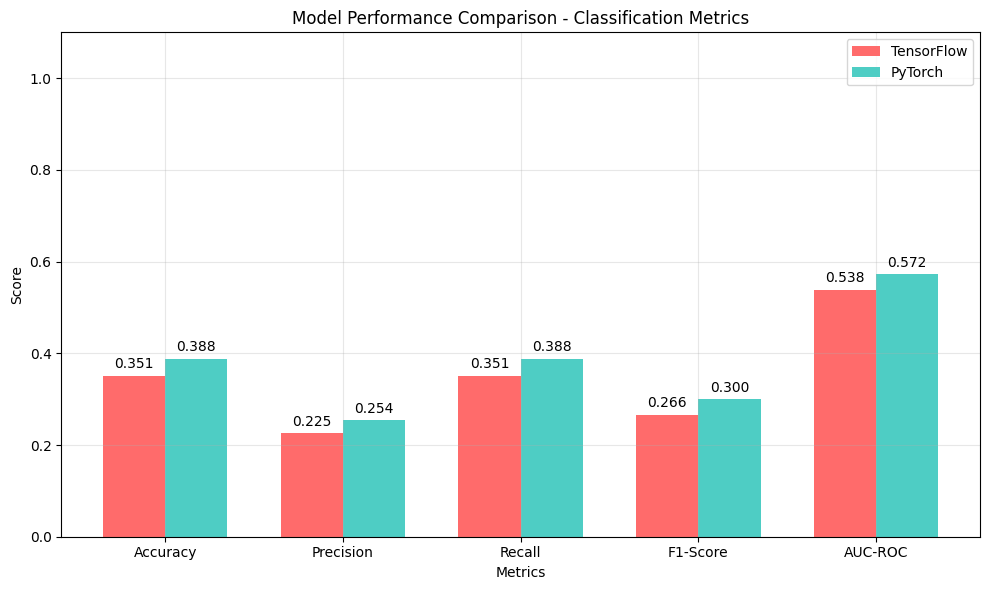


🏆 Model Selection Summary:
TensorFlow wins: 0/5 metrics
PyTorch wins: 5/5 metrics
TensorFlow average score: 0.3463
PyTorch average score: 0.3803

🥇 Best Model: PyTorch CNN


In [ ]:
def create_metrics_comparison(tf_metrics: Dict, pytorch_metrics: Dict) -> pd.DataFrame:
    """
    Create comparison table for the required metrics.
    """
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

    comparison_data = {
        'Metric': metrics_names,
        'TensorFlow CNN': [tf_metrics[m] for m in metrics_names],
        'PyTorch CNN': [pytorch_metrics[m] for m in metrics_names],
    }

    df = pd.DataFrame(comparison_data)
    df['Difference'] = df['TensorFlow CNN'] - df['PyTorch CNN']
    df['Better Model'] = df['Difference'].apply(lambda x: 'TensorFlow' if x > 0 else 'PyTorch')

    return df

# Create comparison
comparison_df = create_metrics_comparison(tf_metrics, pytorch_metrics)

print("\n📊 Model Performance Comparison:")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['TensorFlow CNN'], width,
                label='TensorFlow', color='#FF6B6B')
bars2 = ax.bar(x + width/2, comparison_df['PyTorch CNN'], width,
                label='PyTorch', color='#4ECDC4')

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison - Classification Metrics')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metric'])
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.1])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#Determine Best Model
def determine_best_model(comparison_df):
    """
    Determine the best model based on all metrics.
    """
    # Count wins
    tf_wins = (comparison_df['Better Model'] == 'TensorFlow').sum()
    pytorch_wins = (comparison_df['Better Model'] == 'PyTorch').sum()

    # Calculate average performance
    tf_avg = comparison_df['TensorFlow CNN'].mean()
    pytorch_avg = comparison_df['PyTorch CNN'].mean()

    print("\n🏆 Model Selection Summary:")
    print(f"TensorFlow wins: {tf_wins}/5 metrics")
    print(f"PyTorch wins: {pytorch_wins}/5 metrics")
    print(f"TensorFlow average score: {tf_avg:.4f}")
    print(f"PyTorch average score: {pytorch_avg:.4f}")

    best_model = 'TensorFlow CNN' if tf_avg > pytorch_avg else 'PyTorch CNN'
    print(f"\n🥇 Best Model: {best_model}")

    return best_model

best_model = determine_best_model(comparison_df)

# Penjelasan Matematis Lengkap Pipeline CNN untuk Estimasi Ukuran Ikan

## 1. Fondasi Matematika Convolutional Neural Network (CNN)

### 1.1 Operasi Konvolusi Multi-Channel

Untuk input 3D dengan $C$ channels, height $H$, dan width $W$:

$$
\mathbf{Y}[c_{out}, i, j] = \sum_{c_{in}=0}^{C-1} \sum_{k_h=0}^{K_h-1} \sum_{k_w=0}^{K_w-1} \mathbf{X}[c_{in}, i + k_h, j + k_w] \cdot \mathbf{W}[c_{out}, c_{in}, k_h, k_w] + b[c_{out}]
$$

Dimana:
- $\mathbf{X} \in \mathbb{R}^{C \times H \times W}$: tensor input
- $\mathbf{W} \in \mathbb{R}^{C_{out} \times C_{in} \times K_h \times K_w}$: weight tensor
- $b \in \mathbb{R}^{C_{out}}$: bias vector
- $\mathbf{Y} \in \mathbb{R}^{C_{out} \times H_{out} \times W_{out}}$: output tensor

### 1.2 Perhitungan Dimensi Output

Dengan padding $P$ dan stride $S$:

$$
H_{out} = \left\lfloor \frac{H + 2P - K_h}{S} \right\rfloor + 1
$$

$$
W_{out} = \left\lfloor \frac{W + 2P - K_w}{S} \right\rfloor + 1
$$

### 1.3 Receptive Field

Receptive field pada layer ke-$l$ dihitung rekursif:

$$
RF_l = RF_{l-1} + (K_l - 1) \cdot \prod_{i=1}^{l-1} S_i
$$

Dimana $RF_0 = 1$ untuk input layer.

## 2. Fungsi Aktivasi dan Turunannya

### 2.1 ReLU (Rectified Linear Unit)

$$
\text{ReLU}(x) = \max(0, x) = \begin{cases}
x & \text{if } x > 0 \\
0 & \text{if } x \leq 0
\end{cases}
$$

Turunan:
$$
\frac{d}{dx}\text{ReLU}(x) = \begin{cases}
1 & \text{if } x > 0 \\
0 & \text{if } x \leq 0
\end{cases}
$$

### 2.2 Leaky ReLU

$$
\text{LeakyReLU}(x) = \begin{cases}
x & \text{if } x > 0 \\
\alpha x & \text{if } x \leq 0
\end{cases}
$$

dengan $\alpha = 0.01$ (default).

### 2.3 Swish/SiLU

$$
\text{Swish}(x) = x \cdot \sigma(x) = \frac{x}{1 + e^{-x}}
$$

Turunan:
$$
\frac{d}{dx}\text{Swish}(x) = \sigma(x) + x \cdot \sigma(x)(1 - \sigma(x))
$$

## 3. Batch Normalization - Analisis Mendalam

### 3.1 Forward Pass

Untuk mini-batch $\mathcal{B} = \{x_1, x_2, \ldots, x_m\}$:

$$
\mu_{\mathcal{B}} = \frac{1}{m} \sum_{i=1}^{m} x_i
$$

$$
\sigma_{\mathcal{B}}^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_{\mathcal{B}})^2
$$

$$
\hat{x}_i = \frac{x_i - \mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^2 + \epsilon}}
$$

$$
y_i = \gamma \hat{x}_i + \beta
$$

### 3.2 Backward Pass

Gradien terhadap parameter:
$$
\frac{\partial \mathcal{L}}{\partial \gamma} = \sum_{i=1}^{m} \frac{\partial \mathcal{L}}{\partial y_i} \hat{x}_i
$$

$$
\frac{\partial \mathcal{L}}{\partial \beta} = \sum_{i=1}^{m} \frac{\partial \mathcal{L}}{\partial y_i}
$$

Gradien terhadap input:
$$
\frac{\partial \mathcal{L}}{\partial x_i} = \frac{\gamma}{\sqrt{\sigma_{\mathcal{B}}^2 + \epsilon}} \left[ \frac{\partial \mathcal{L}}{\partial y_i} - \frac{1}{m}\sum_{j=1}^{m}\frac{\partial \mathcal{L}}{\partial y_j} - \frac{\hat{x}_i}{m}\sum_{j=1}^{m}\frac{\partial \mathcal{L}}{\partial y_j}\hat{x}_j \right]
$$

### 3.3 Moving Average untuk Inference

$$
\mu_{running} = (1 - \alpha) \mu_{running} + \alpha \mu_{\mathcal{B}}
$$

$$
\sigma_{running}^2 = (1 - \alpha) \sigma_{running}^2 + \alpha \sigma_{\mathcal{B}}^2
$$

dengan momentum $\alpha = 0.1$.

## 4. Pooling Operations

### 4.1 Max Pooling

$$
y_{i,j} = \max_{0 \leq p < P, 0 \leq q < Q} x_{i \cdot S + p, j \cdot S + q}
$$

### 4.2 Average Pooling

$$
y_{i,j} = \frac{1}{P \cdot Q} \sum_{p=0}^{P-1} \sum_{q=0}^{Q-1} x_{i \cdot S + p, j \cdot S + q}
$$

### 4.3 Global Average Pooling

$$
y_c = \frac{1}{H \cdot W} \sum_{i=0}^{H-1} \sum_{j=0}^{W-1} x_{c,i,j}
$$

## 5. Regularization Techniques

### 5.1 Dropout

Selama training:
$$
\tilde{x}_i = \begin{cases}
0 & \text{dengan probabilitas } p \\
\frac{x_i}{1-p} & \text{dengan probabilitas } 1-p
\end{cases}
$$

Inverted dropout memastikan ekspektasi output tetap sama:
$$
E[\tilde{x}_i] = (1-p) \cdot \frac{x_i}{1-p} + p \cdot 0 = x_i
$$

### 5.2 L2 Regularization (Weight Decay)

Loss function dengan regularisasi:
$$
\mathcal{L}_{total} = \mathcal{L}_{data} + \lambda \sum_{l} \|\mathbf{W}_l\|_2^2
$$

Dimana $\|\mathbf{W}_l\|_2^2 = \sum_{i,j} W_{l,i,j}^2$.

## 6. Optimization - Adam Algorithm

### 6.1 Momentum Estimates

First moment (mean):
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$

Second moment (uncentered variance):
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

### 6.2 Bias Correction

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}
$$

$$
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

### 6.3 Parameter Update

$$
\theta_t = \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

### 6.4 Adaptive Learning Rate

Effective learning rate untuk parameter $i$:
$$
\alpha_{eff,i} = \alpha \frac{\hat{m}_{t,i}}{\sqrt{\hat{v}_{t,i}} + \epsilon}
$$

## 7. Loss Functions

### 7.1 Mean Squared Error (MSE)

$$
\mathcal{L}_{MSE} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)^2
$$

Gradien terhadap prediksi:
$$
\frac{\partial \mathcal{L}_{MSE}}{\partial \hat{y}_i} = \frac{2}{N}(\hat{y}_i - y_i)
$$

### 7.2 Mean Absolute Error (MAE)

$$
\mathcal{L}_{MAE} = \frac{1}{N} \sum_{i=1}^{N} |\hat{y}_i - y_i|
$$

### 7.3 Huber Loss

$$
\mathcal{L}_{Huber} = \frac{1}{N} \sum_{i=1}^{N} \begin{cases}
\frac{1}{2}(\hat{y}_i - y_i)^2 & \text{if } |\hat{y}_i - y_i| \leq \delta \\
\delta |\hat{y}_i - y_i| - \frac{1}{2}\delta^2 & \text{otherwise}
\end{cases}
$$

## 8. Data Augmentation - Transformasi Matematika

### 8.1 Geometric Transformations

**Rotasi:**
$$
\begin{bmatrix}
x' \\
y'
\end{bmatrix} =
\begin{bmatrix}
\cos\theta & -\sin\theta \\
\sin\theta & \cos\theta
\end{bmatrix}
\begin{bmatrix}
x \\
y
\end{bmatrix}
$$

**Scaling:**
$$
\begin{bmatrix}
x' \\
y'
\end{bmatrix} =
\begin{bmatrix}
s_x & 0 \\
0 & s_y
\end{bmatrix}
\begin{bmatrix}
x \\
y
\end{bmatrix}
$$

### 8.2 Photometric Transformations

**Brightness adjustment:**
$$
I'(x,y) = I(x,y) + \beta
$$

**Contrast adjustment:**
$$
I'(x,y) = \alpha \cdot I(x,y)
$$

**Gamma correction:**
$$
I'(x,y) = I(x,y)^{\gamma}
$$

### 8.3 Noise Injection

**Gaussian noise:**
$$
I'(x,y) = I(x,y) + \mathcal{N}(0, \sigma^2)
$$

## 9. Konversi Regression ke Classification

### 9.1 Quantile-based Binning

Untuk data target $\{y_1, y_2, \ldots, y_N\}$, buat $K$ bins dengan quantiles:

$$
q_k = \text{quantile}(y, \frac{k}{K}), \quad k = 0, 1, \ldots, K
$$

### 9.2 Equal-width Binning

$$
\text{bin}_k = \left[\frac{k \cdot (\max(y) - \min(y))}{K} + \min(y), \frac{(k+1) \cdot (\max(y) - \min(y))}{K} + \min(y)\right)
$$

### 9.3 Label Assignment

$$
\text{label}_i = \arg\max_k \mathbb{I}(q_{k-1} \leq y_i < q_k)
$$

## 10. Evaluation Metrics

### 10.1 Classification Metrics

**Precision untuk kelas $k$:**
$$
\text{Precision}_k = \frac{TP_k}{TP_k + FP_k}
$$

**Recall untuk kelas $k$:**
$$
\text{Recall}_k = \frac{TP_k}{TP_k + FN_k}
$$

**F1-Score:**
$$
F1_k = 2 \cdot \frac{\text{Precision}_k \cdot \text{Recall}_k}{\text{Precision}_k + \text{Recall}_k}
$$

### 10.2 Multi-class ROC-AUC

One-vs-Rest approach:
$$
\text{AUC}_{macro} = \frac{1}{K} \sum_{k=1}^{K} \text{AUC}_k
$$

One-vs-One approach:
$$
\text{AUC}_{ovo} = \frac{2}{K(K-1)} \sum_{i=1}^{K} \sum_{j=i+1}^{K} \text{AUC}_{ij}
$$

### 10.3 Regression Metrics

**Mean Absolute Percentage Error (MAPE):**
$$
\text{MAPE} = \frac{100\%}{N} \sum_{i=1}^{N} \left|\frac{y_i - \hat{y}_i}{y_i}\right|
$$

**Root Mean Square Error (RMSE):**
$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}
$$

**R-squared (Coefficient of Determination):**
$$
R^2 = 1 - \frac{\sum_{i=1}^{N} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{N} (y_i - \bar{y})^2}
$$

## 11. Learning Rate Scheduling

### 11.1 Step Decay

$$
\alpha_t = \alpha_0 \cdot \gamma^{\lfloor t/s \rfloor}
$$

### 11.2 Exponential Decay

$$
\alpha_t = \alpha_0 \cdot e^{-\lambda t}
$$

### 11.3 Cosine Annealing

$$
\alpha_t = \alpha_{min} + \frac{1}{2}(\alpha_{max} - \alpha_{min})\left(1 + \cos\left(\frac{t}{T}\pi\right)\right)
$$

### 11.4 Warm Restart

$$
\alpha_t = \alpha_{min} + \frac{1}{2}(\alpha_{max} - \alpha_{min})\left(1 + \cos\left(\frac{T_{cur}}{T_i}\pi\right)\right)
$$

dimana $T_{cur}$ adalah epoch dalam restart cycle saat ini.

## 12. Gradient Computation dan Backpropagation

### 12.1 Chain Rule

Untuk layer $l$ dengan input $x_l$ dan output $y_l = f_l(x_l)$:

$$
\frac{\partial \mathcal{L}}{\partial x_l} = \frac{\partial \mathcal{L}}{\partial y_l} \cdot \frac{\partial y_l}{\partial x_l}
$$

### 12.2 Gradient untuk Konvolusi

Gradien terhadap weight:
$$
\frac{\partial \mathcal{L}}{\partial W_{i,j}} = \sum_{m,n} \frac{\partial \mathcal{L}}{\partial Y_{m,n}} \cdot X_{m+i,n+j}
$$

Gradien terhadap input:
$$
\frac{\partial \mathcal{L}}{\partial X_{i,j}} = \sum_{m,n} \frac{\partial \mathcal{L}}{\partial Y_{m,n}} \cdot W_{i-m,j-n}
$$

## 13. Memory Optimization

### 13.1 Gradient Checkpointing

Trade-off antara memory dan computation dengan menyimpan aktivasi pada checkpoint tertentu:

$$
\text{Memory} = O(\sqrt{n}) \text{ vs } O(n) \text{ tanpa checkpointing}
$$

### 13.2 Mixed Precision Training

Menggunakan FP16 untuk forward pass dan FP32 untuk backward pass:

$$
\text{Loss scaling: } \mathcal{L}_{scaled} = S \cdot \mathcal{L}
$$

## 14. Statistical Analysis

### 14.1 Confidence Intervals

Untuk prediksi regression dengan asumsi normal:

$$
CI = \hat{y} \pm t_{\alpha/2, n-1} \cdot \frac{s}{\sqrt{n}}
$$

### 14.2 Prediction Intervals

$$
PI = \hat{y} \pm t_{\alpha/2, n-1} \cdot s \sqrt{1 + \frac{1}{n}}
$$

### 14.3 Bootstrap Confidence Intervals

Untuk $B$ bootstrap samples:

$$
CI_{boot} = [\hat{y}_{(B \cdot \alpha/2)}, \hat{y}_{(B \cdot (1-\alpha/2))}]
$$

## 15. Model Selection dan Validation

### 15.1 Cross-Validation

K-fold CV error:
$$
CV_K = \frac{1}{K} \sum_{k=1}^{K} \mathcal{L}(\mathcal{D}_{train}^{(k)}, \mathcal{D}_{val}^{(k)})
$$

### 15.2 Information Criteria

**Akaike Information Criterion (AIC):**
$$
AIC = 2k - 2\ln(\mathcal{L})
$$

**Bayesian Information Criterion (BIC):**
$$
BIC = k\ln(n) - 2\ln(\mathcal{L})
$$

dimana $k$ adalah jumlah parameter dan $n$ adalah ukuran sampel.

## 16. Implementasi Praktis

### 16.1 Numerical Stability

**Softmax numerically stable:**
$$
\text{softmax}(x_i) = \frac{e^{x_i - \max(x)}}{\sum_{j} e^{x_j - \max(x)}}
$$

**Log-sum-exp trick:**
$$
\log\left(\sum_{i} e^{x_i}\right) = a + \log\left(\sum_{i} e^{x_i - a}\right)
$$

dimana $a = \max(x)$.

### 16.2 Gradient Clipping

**L2 norm clipping:**
$$
\mathbf{g} = \begin{cases}
\mathbf{g} & \text{if } \|\mathbf{g}\|_2 \leq c \\
c \cdot \frac{\mathbf{g}}{\|\mathbf{g}\|_2} & \text{otherwise}
\end{cases}
$$

**Value clipping:**
$$
g_i = \max(-c, \min(c, g_i))
$$

---

## Kesimpulan

Pipeline CNN untuk estimasi ukuran ikan melibatkan kompleksitas matematis yang mendalam, mulai dari operasi konvolusi dasar hingga teknik optimasi advanced. Pemahaman yang solid terhadap fondasi matematika ini memungkinkan implementasi yang efisien dan debugging yang efektif ketika model tidak berkinerja sesuai ekspektasi.

Setiap komponen dalam pipeline memiliki justifikasi matematis yang kuat, dan pemilihan hyperparameter harus didasarkan pada pemahaman teoritis serta validasi empiris untuk mencapai performa optimal dalam task regression-to-classification untuk estimasi ukuran ikan.